
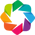

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import pandas_datareader.data as web
import datetime 
from datetime import timedelta
import seaborn as sns 
from scipy import stats
from scipy.stats import norm
from scipy.stats import skew
sns.set(style = "whitegrid", color_codes = True)
sns.set(font_scale = 1)
from itertools import tee

from utils.bollinger_band import bollinger_bands, rolling_mean, rolling_std, candlestick
from utils.utils import get_data_frame_for_symbols, get_data_frame, spy_data_frame, pairwise
from utils.get_stats import get_stocks_stas, compute_daily_return

import holoviews as hv
hv.extension('bokeh')

## Bollinger band

In [2]:
spx = pd.read_csv('data/SPX.csv')
spx.Date = spx.Date.apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
spx.set_index('Date', inplace= True)

Populating the interactive namespace from numpy and matplotlib


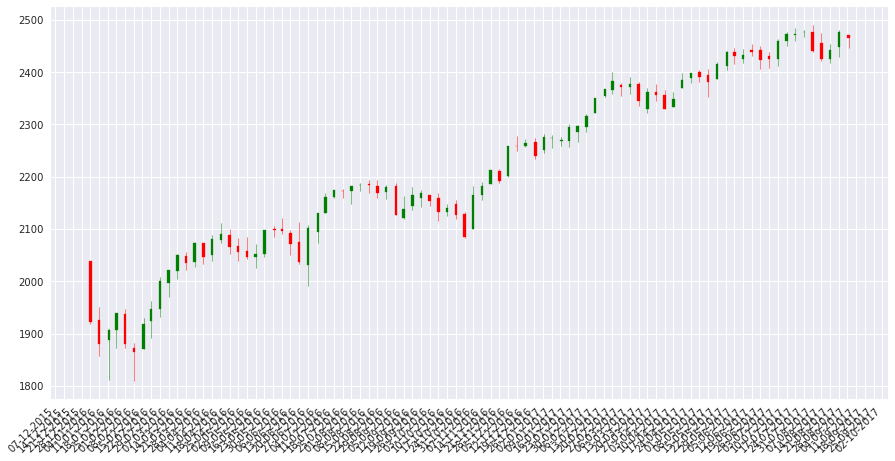

In [4]:
candlestick(spx, 'week')
plt.savefig('figure/candlestick_spx')

In [11]:
%%opts 
start_date = '2017-01-01'
end_date = '2017-09-01'
list_stocks = ['AAPL','GOOG','AMZN','AXP','BAC','BA','KO','FB','IBM','GE', 'GS','HP', 'XOM', 'F']
list_stocks = ['AAPL']
stock = 'AAPL'
data_frame = get_data_frame_for_symbols([stock], start_date, end_date)
data_to_plot =  data_frame[stock]
data_to_plot.dropna(inplace=True)
data_to_plot = pd.DataFrame(data_to_plot)

data_to_plot['rolling_mean'] = rolling_mean(data_to_plot)
data_to_plot['upper_band'] = data_to_plot['rolling_mean'] + (2 * rolling_std(data_to_plot[stock]))
data_to_plot['lower_band'] = data_to_plot['rolling_mean'] - (2 * rolling_std(data_to_plot[stock]))


%%opts Curve.Main.upper [width=900 height=400 show_frame=False tools=['hover']] (color='r' line_width=3)
%%opts Curve.Main.lower [width=900 height=400 show_frame=False tools=['hover']] (color='black' line_width=3)
%%opts Curve.Main.rolling [width=900 height=400 show_frame=False tools=['hover']] (color='g' line_width=3)
%%opts Curve.Main.price [width=900 height=400 show_frame=False tools=['hover']] (color='b' line_width=3)

#%%opts Spikes.Main.Order [width=700 height=400 show_frame=False tools=['hover']] (color='g' line_width=3)

macro_df = pd.DataFrame(data_to_plot).copy()
macro_df.index.names = ['date']
#macro_df.fillna(0 , inplace= True)
macro_df.reset_index(inplace=True)

key_dimensions   = [("date", "Date")]
value_dimensions = [('upper_band', 'upper_band'), 
                    ('rolling_mean', 'rollng_mean'), 
                    ("lower_band", "lower_band"),
                    (stock, 'stock')]

macro = hv.Table(macro_df, kdims=key_dimensions, vdims=value_dimensions)

ub= macro.to(hv.Curve, kdims=['Date'], vdims=['upper_band'], group='Main', label='upper')
rm = macro.to(hv.Curve, kdims=['Date'], vdims=['rolling_mean'], group='Main', label='rolling')
lb = macro.to(hv.Curve, kdims=['Date'], vdims=['lower_band'], group='Main', label='lower')
st = macro.to(hv.Curve, kdims=['Date'], vdims=['stock'], group='Main', label='price')
ub * rm  * lb * st

:Overlay
   .Main.Upper   :Curve   [date]   (upper_band)
   .Main.Rolling :Curve   [date]   (rolling_mean)
   .Main.Lower   :Curve   [date]   (lower_band)
   .Main.Price   :Curve   [date]   (AAPL)

### Strategie 1: Bollinger_band strategie

In [33]:
f = open('order/orders_bollingerstrategy.txt',"w")
f.write('Date,Ticker,Order,Volumn\n')

25

In [34]:
def generate_orders(stock, start, end):
    #calculate the moving average (20 day range) and bollinger bands
    data_frame = get_data_frame_for_symbols([stock], start, end)
    data_to_plot =  data_frame[stock]
    data_to_plot.dropna(inplace=True)
    data_to_plot = pd.DataFrame(data_to_plot)
    
    data_to_plot['rolling_mean'] = rolling_mean(data_to_plot, window = 20)
    data_to_plot['upper_band'] = data_to_plot['rolling_mean'] + (2 * rolling_std(data_to_plot[stock], window = 20))
    data_to_plot['lower_band'] = data_to_plot['rolling_mean'] - (2 * rolling_std(data_to_plot[stock], window = 20))
    
    #find the points where the price crosses over the bollinger bands 
    long_entries = []
    short_entries = []
    exits = []
    currently_holding_long = "debut"
    currently_holding_short = "debut"
    
    #all order opportunities will be written 
    f = open('order/orders_bollingerstrategy.txt','a')
    
    for (index1, row1), (index2, row2) in pairwise(pd.DataFrame(data_to_plot).iterrows()):
        #on va long l'action
        if (row1[stock] < row1['lower_band'] and row2[stock] > row2['lower_band'] and (currently_holding_long == "F" or currently_holding_long == "debut")):
            long_entries.append(str(index2)[:10])
            currently_holding_long = "T"
            f.write("{},{},BUY,100\n".format(str(index2)[:10], stock))

        #vendre l'action que l'on long
        elif(row1[stock] < row1['rolling_mean'] and row2[stock] > row2['rolling_mean'] and currently_holding_long == "T"):
            exits.append(str(index2)[:10])
            currently_holding_long = "F"
            f.write("{},{},SELL,100\n".format(str(index2)[:10], stock))

        #shorting l'action
        elif(row1[stock] > row1['upper_band'] and row2[stock] < row2['upper_band'] and (currently_holding_short == "F" or currently_holding_short == "debut")):
            short_entries.append(str(index2)[:10])
            currently_holding_short = "T"
            f.write("{},{},SHORT,100\n".format(str(index2)[:10], stock))

        #vendre le short
        elif(row1[stock] > row1['rolling_mean'] and row2[stock] < row2['rolling_mean'] and currently_holding_short == "T"):
            exits.append(str(index2)[:10])
            currently_holding_short = "F"
            f.write("{},{},SELL_SHORT,100\n".format(str(index2)[:10], stock))
    f.close()
    
    ax = pd.DataFrame(data_to_plot).plot(fontsize=12, figsize = (15,8))
    ax.fill_between(data_to_plot.index, data_to_plot['upper_band'].values, data_to_plot['lower_band'].values, alpha=0.2)

    ax.set_xlabel("Date")
    ax.set_ylabel("Values")
    for i, val in enumerate(long_entries):
        ax.axvline(x=val, ymin=0, ymax = 100, linewidth=.8, color='green')
    for i, val in enumerate(short_entries):
        ax.axvline(x=val, ymin=0, ymax = 100, linewidth=.8, color='red')
    for i, val in enumerate(exits):
        ax.axvline(x=val, ymin=0, ymax = 100, linewidth=.8, color='black')
    plt.savefig('figure/strategy1/{}'.format(stock))
    
    %%opts Curve.Main.upper [width=900 height=400 show_frame=False tools=['hover']] (color='r' line_width=3)
    %%opts Curve.Main.lower [width=900 height=400 show_frame=False tools=['hover']] (color='b' line_width=3)
    %%opts Curve.Main.rolling [width=900 height=400 show_frame=False tools=['hover']] (color='g' line_width=3)
    %%opts Curve.Main.price [width=900 height=400 show_frame=False tools=['hover']] (color='b' line_width=3)

    macro_df = pd.DataFrame(data_to_plot).copy()
    macro_df.index.names = ['date']
    #macro_df.fillna(0 , inplace= True)
    macro_df.reset_index(inplace=True)

    key_dimensions   = [("date", "Date")]
    value_dimensions = [('upper_band', 'upper_band'), 
                        ('rolling_mean', 'rollng_mean'), 
                        ("lower_band", "lower_band"),
                        (stock, 'stock')]

    macro = hv.Table(macro_df, kdims=key_dimensions, vdims=value_dimensions)

    ub= macro.to(hv.Curve, kdims=['Date'], vdims=['upper_band'], group='Main', label='upper')
    rm = macro.to(hv.Curve, kdims=['Date'], vdims=['rolling_mean'], group='Main', label='rolling')
    lb = macro.to(hv.Curve, kdims=['Date'], vdims=['lower_band'], group='Main', label='lower')
    st = macro.to(hv.Curve, kdims=['Date'], vdims=['stock'], group='Main', label='price')
    ub * rm  * lb * st


In [35]:
start_date = '2016-01-01'
end_date = '2016-12-31'
list_stocks = ['AAPL','GOOG','AMZN','AXP','BAC','BA','KO','FB','IBM','GE', 'GS','HP', 'XOM', 'F']
#list_stocks = ['AAPL']

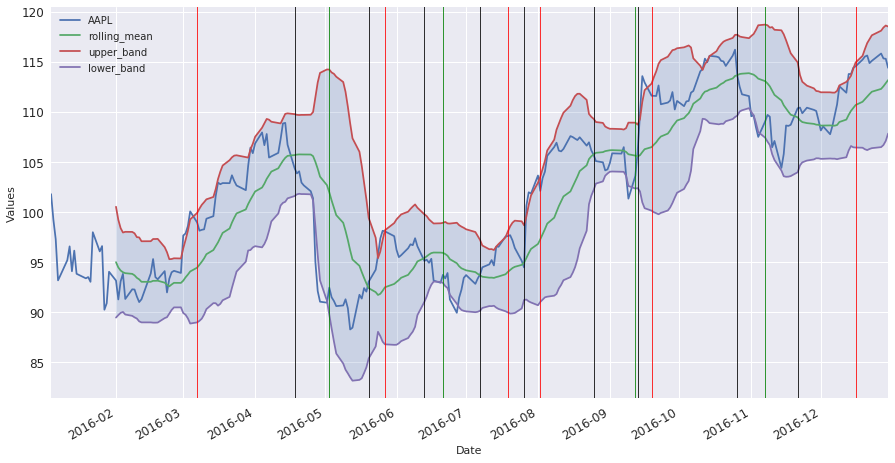

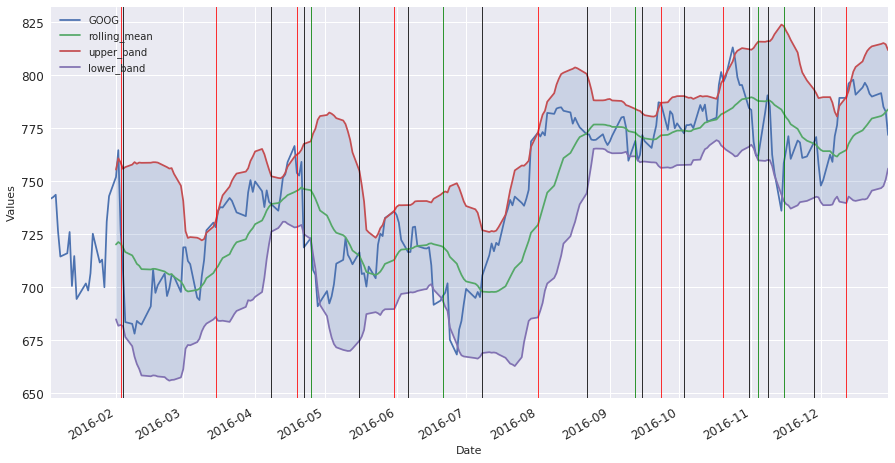

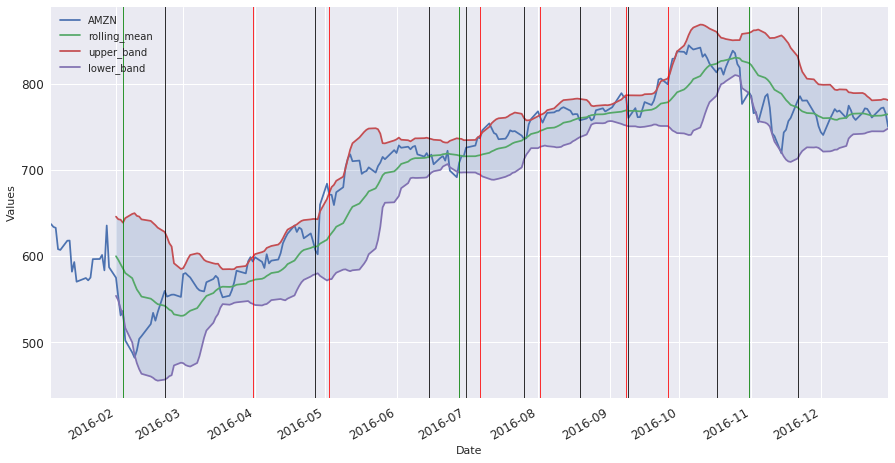

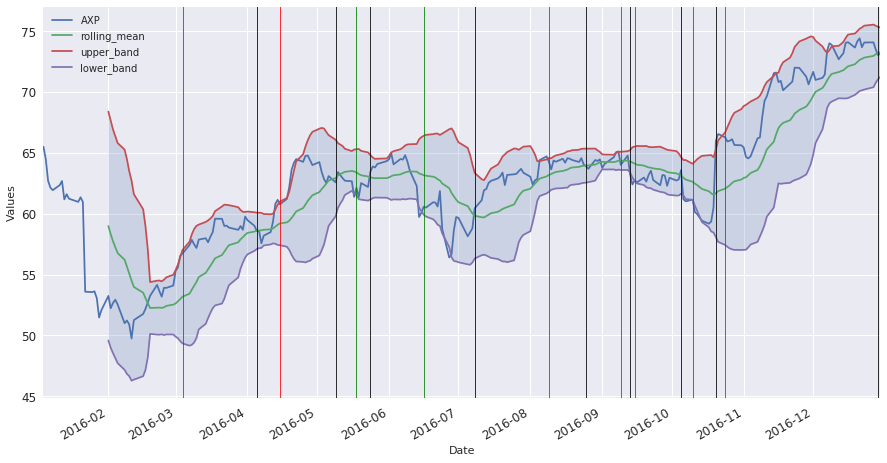

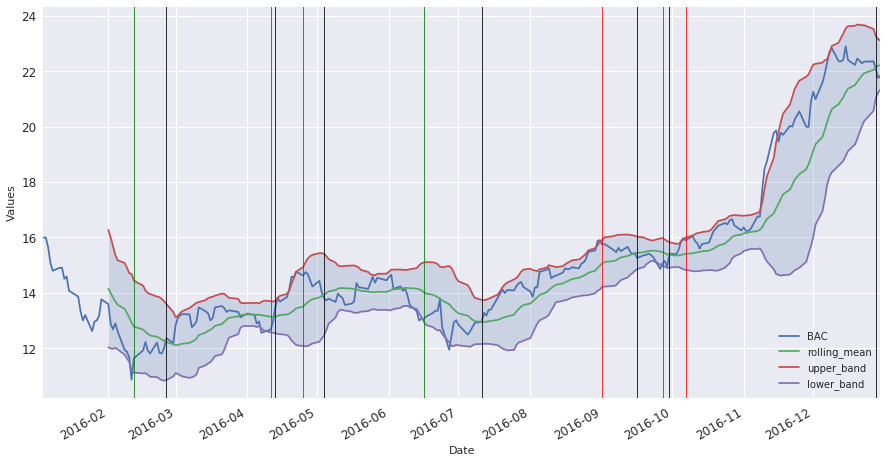

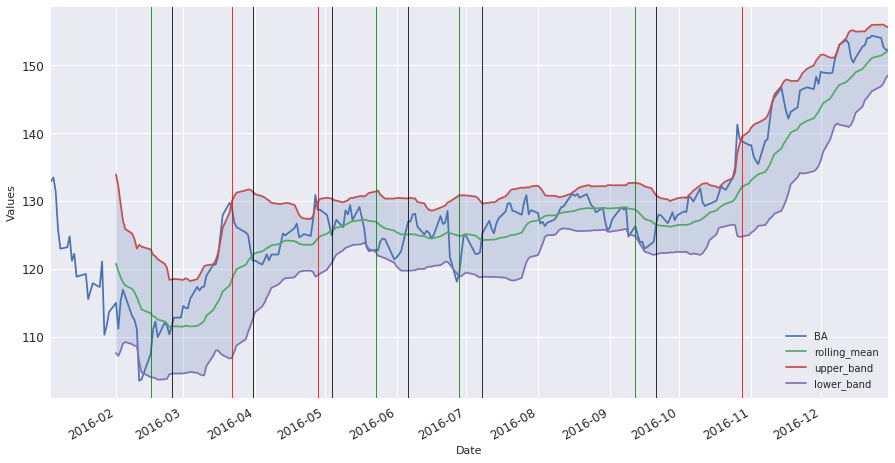

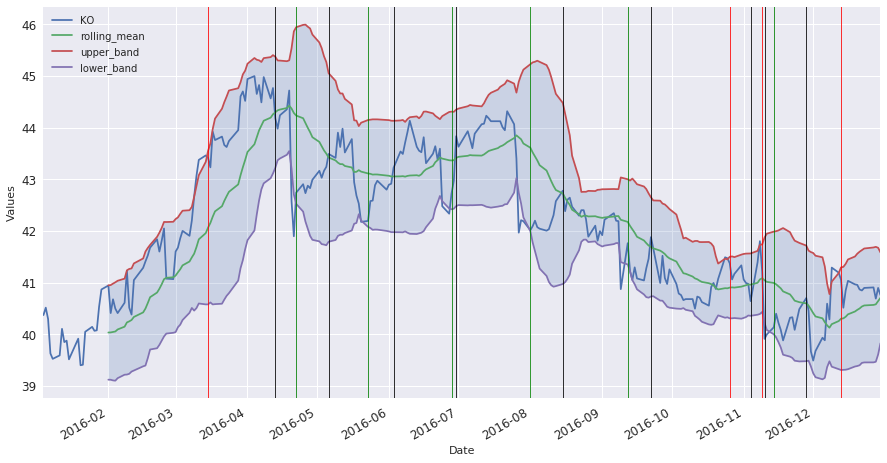

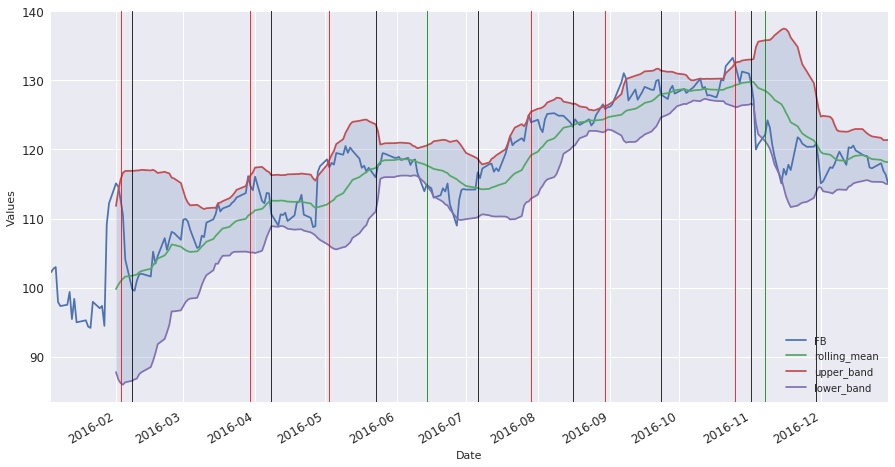

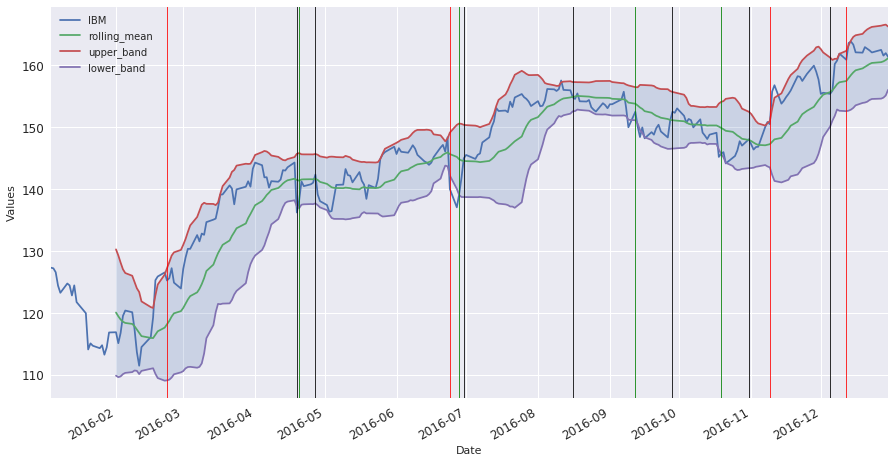

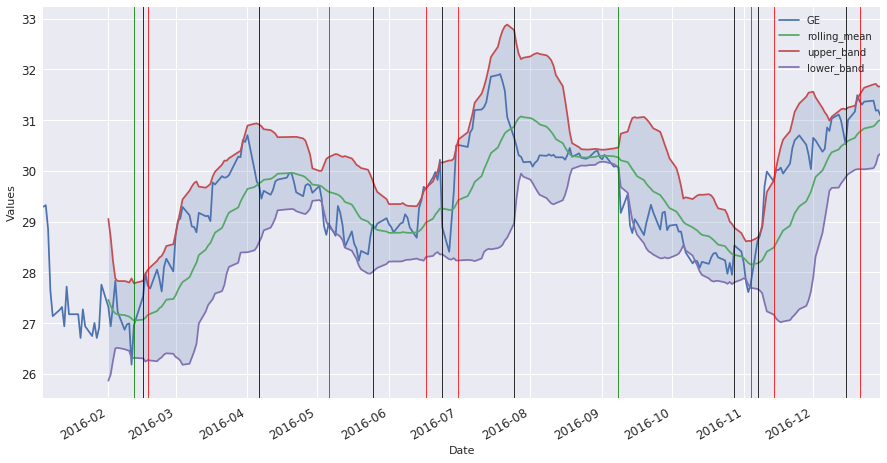

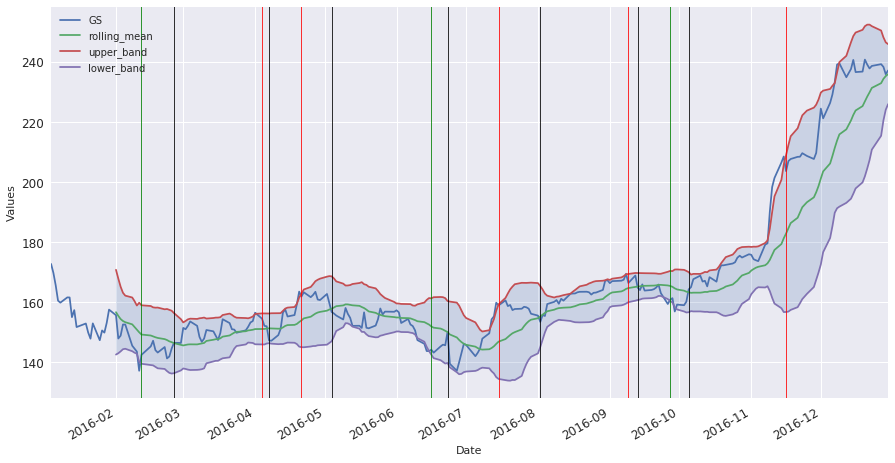

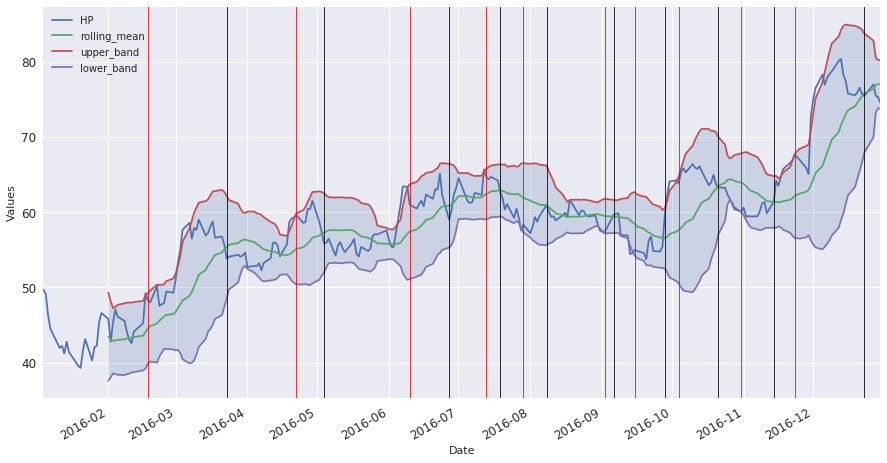

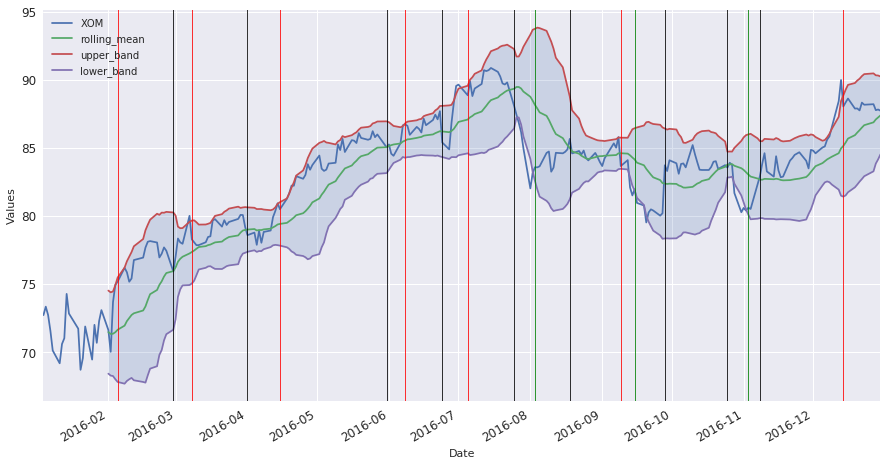

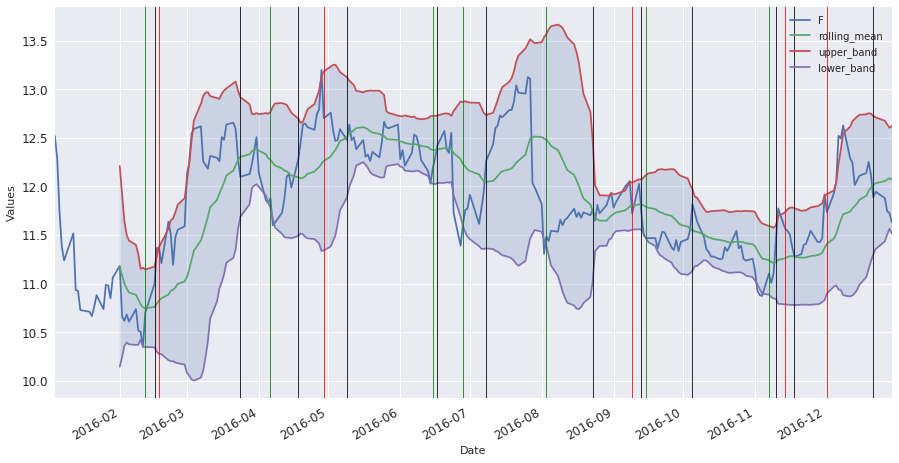

In [36]:
for stock in list_stocks:
    generate_orders(stock, start_date, end_date)

In [37]:
order = pd.read_csv('order/orders_bollingerstrategy.txt')

In [38]:
order.head()

Date Ticker       Order  Volumn
0  2016-03-07   AAPL       SHORT     100
1  2016-04-18   AAPL  SELL_SHORT     100
2  2016-05-03   AAPL         BUY     100
3  2016-05-20   AAPL        SELL     100
4  2016-05-27   AAPL       SHORT     100

### Strategie 2: 

In [42]:
f = open('order/orders_strategy_2.txt',"w")
f.write('Date,Ticker,Order,Volumn\n')

25

In [43]:
def generate_orders_2(stock, start, end):
    #calculate the moving average (20 day range) and bollinger bands
    data_frame = get_data_frame_for_symbols([stock], start, end)
    data_frame_spx = get_data_frame('SPX', start, end, dropna= True)
    #data_to_plot =  data_frame[stock]
    #data_to_plot.dropna(inplace=True)
    data_to_plot = pd.concat([data_frame,data_frame_spx], axis = 1)
    
    #for stock
    data_to_plot['rolling_mean'] = rolling_mean(data_to_plot[stock])
    data_to_plot['upper_band'] = data_to_plot['rolling_mean'] + (2 * rolling_std(data_to_plot[stock]))
    data_to_plot['lower_band'] = data_to_plot['rolling_mean'] - (2 * rolling_std(data_to_plot[stock]))
    
    #for SPY
    data_to_plot['SPX_rolling_mean'] = rolling_mean(data_to_plot['SPX'])
    data_to_plot['SPX_upper_band'] = data_to_plot['SPX_rolling_mean'] + (2 * rolling_std(data_to_plot['SPX']))
    data_to_plot['SPX_lower_band'] = data_to_plot['SPX_rolling_mean'] - (2 * rolling_std(data_to_plot['SPX']))
    
    #iterate through the dataframe and find the points where the price crosses over the bollinger bands 
    long_entries = []
    short_entries = []
    exits = []
    currently_holding_long = "debut"
    currently_holding_short = "debut"
    
    #all order opportunities will be written to orders.csv
    f = open('order/orders_strategy_2.txt','a')
    
    for (index1, row1), (index2, row2) in pairwise(data_to_plot.iterrows()):
        bollinger_val = (row2[stock] - row2['rolling_mean'])/(row2['upper_band'] - row2['lower_band'])
        SPY_bollinger_val = (row2['SPX'] - row2['SPX_rolling_mean'])/(row2['SPX_upper_band'] - row2['SPX_lower_band'])

        momentum = 0
        if ((index2-timedelta(days=5)) in data_to_plot.index):
            momentum = (data_to_plot.loc[index2, stock]/data_to_plot.loc[(index2-timedelta(days=5)), stock]) - 1.0

        #long the stock
        if (((row1[stock] < row1['lower_band'] and row2[stock] > row2['lower_band']) or ((bollinger_val - SPY_bollinger_val) < -0.3) and (momentum > 0.25)) and (currently_holding_long == "F" or currently_holding_long == "debut")):
            long_entries.append(str(index2)[:10])
            currently_holding_long = "T"
            f.write("{},{},BUY,100\n".format(str(index2)[:10], stock))

        #sell the stock
        elif(((row1[stock] < row1['rolling_mean'] and row2[stock] > row2['rolling_mean']) or ((bollinger_val - SPY_bollinger_val) > 0.7)) and currently_holding_long == "T"):
            exits.append(str(index2)[:10])
            currently_holding_long = "F"
            f.write("{},{},SELL,100\n".format(str(index2)[:10], stock))

        #start shorting the stock
        elif(((row1[stock] > row1['upper_band'] and row2[stock] < row2['upper_band']) or ((bollinger_val - SPY_bollinger_val) < -0.3) and (momentum < -0.25)) and (currently_holding_short == "F" or currently_holding_short == "debut")):
            short_entries.append(str(index2)[:10])
            currently_holding_short = "T"
            f.write("{},{},SHORT,100\n".format(str(index2)[:10], stock))

        #stop shorting the stock
        elif(((row1[stock] > row1['rolling_mean'] and row2[stock] < row2['rolling_mean']) or ((bollinger_val - SPY_bollinger_val) > 0.7)) and currently_holding_short == "T"):
            exits.append(str(index2)[:10])
            currently_holding_short = "F"
            f.write("{},{},SELL_SHORT,100\n".format(str(index2)[:10], stock))

    f.close()

    ax = pd.DataFrame(data_to_plot[[stock, 'rolling_mean', 'upper_band','lower_band']]).plot(fontsize=12, figsize = (15,8))
    ax.fill_between(data_to_plot.index, data_to_plot['upper_band'].values, data_to_plot['lower_band'].values, alpha=0.2)

    ax.set_xlabel("Date")
    ax.set_ylabel("Values")
    for i, val in enumerate(long_entries):
        ax.axvline(x=val, ymin=0, ymax = 100, linewidth=.5, color='green')
    for i, val in enumerate(short_entries):
        ax.axvline(x=val, ymin=0, ymax = 100, linewidth=.5, color='red')
    for i, val in enumerate(exits):
        ax.axvline(x=val, ymin=0, ymax = 100, linewidth=.5, color='black')
    
    plt.savefig('figure/strategy2/{}'.format(stock))


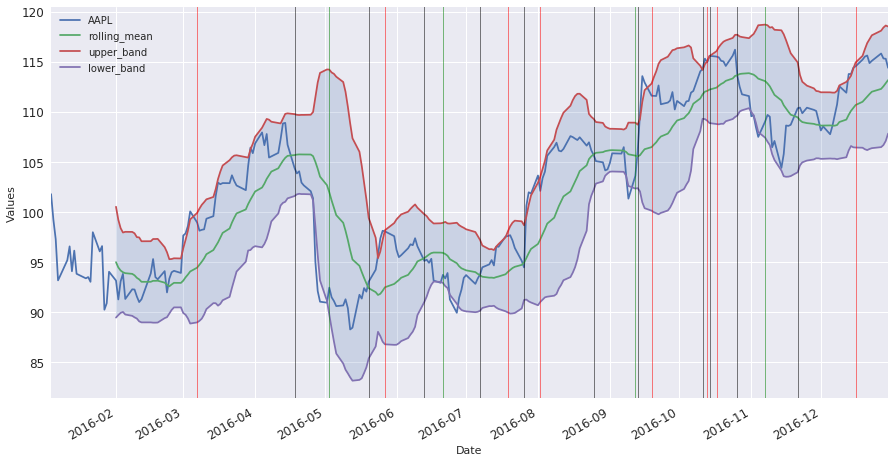

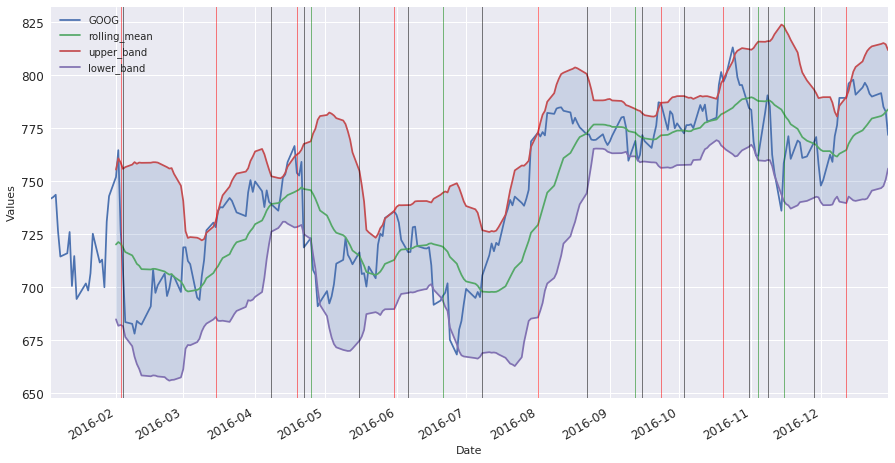

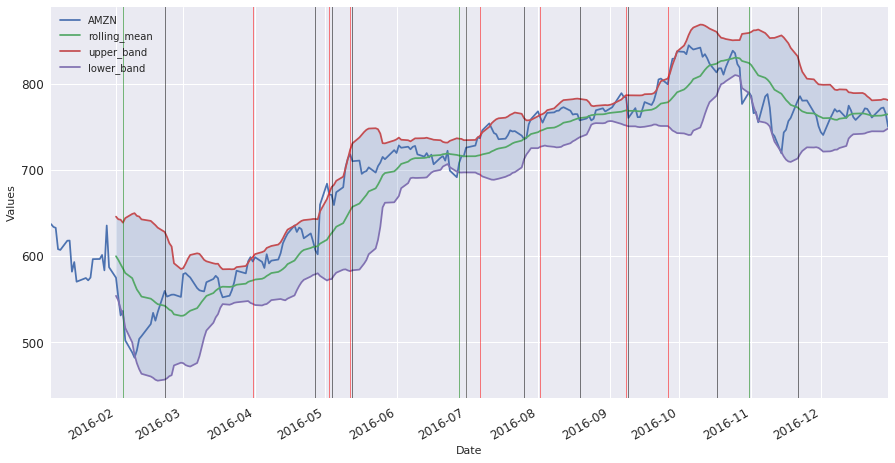

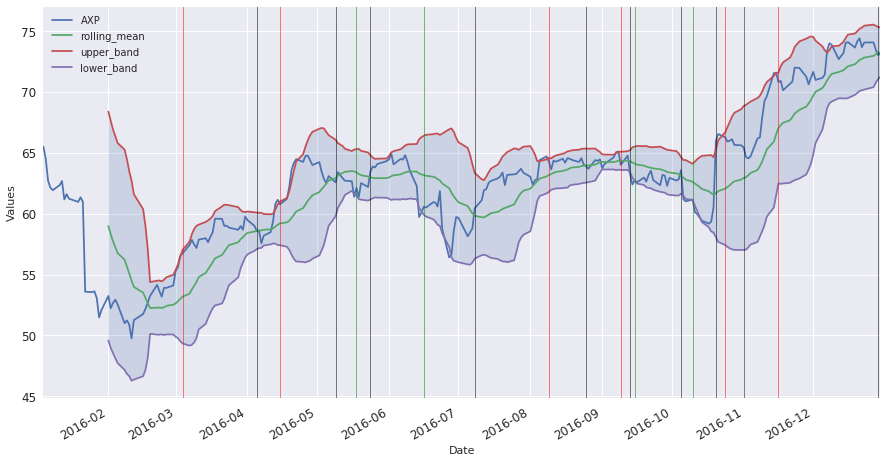

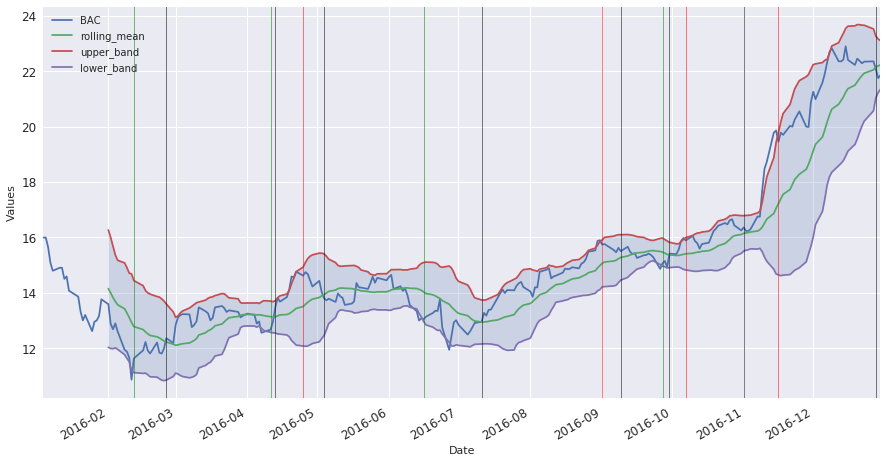

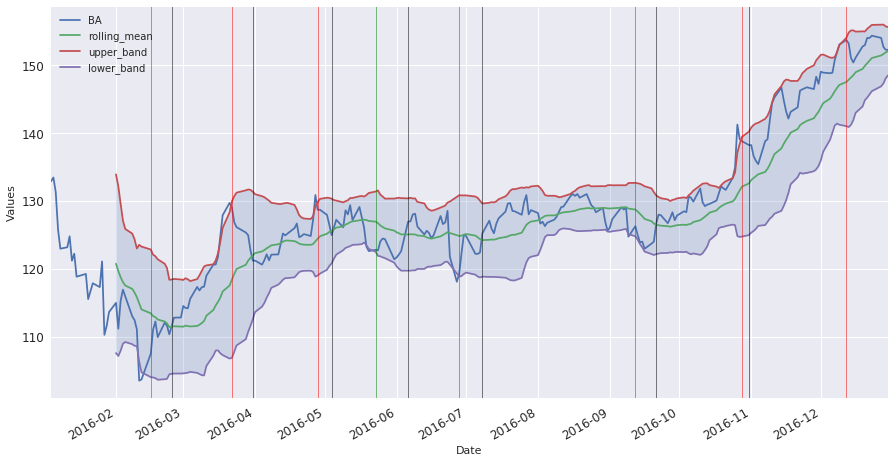

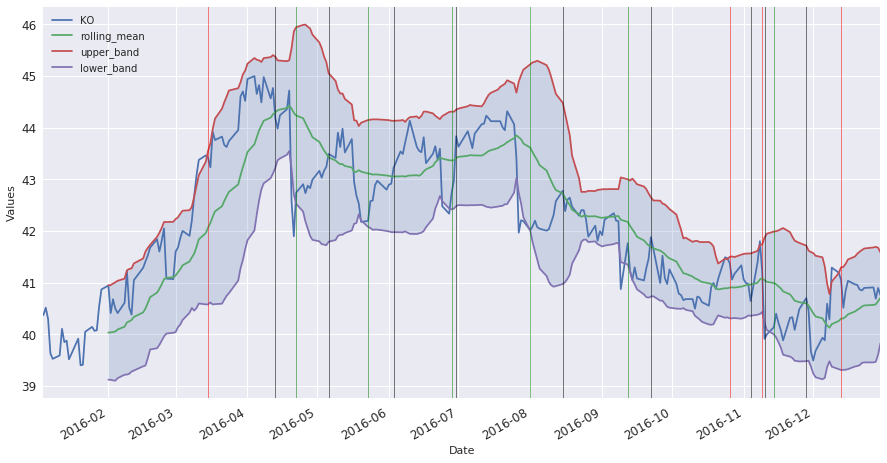

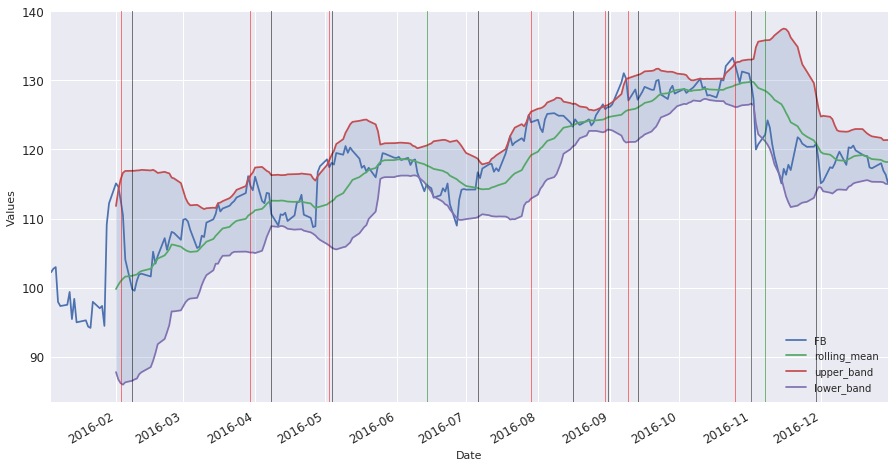

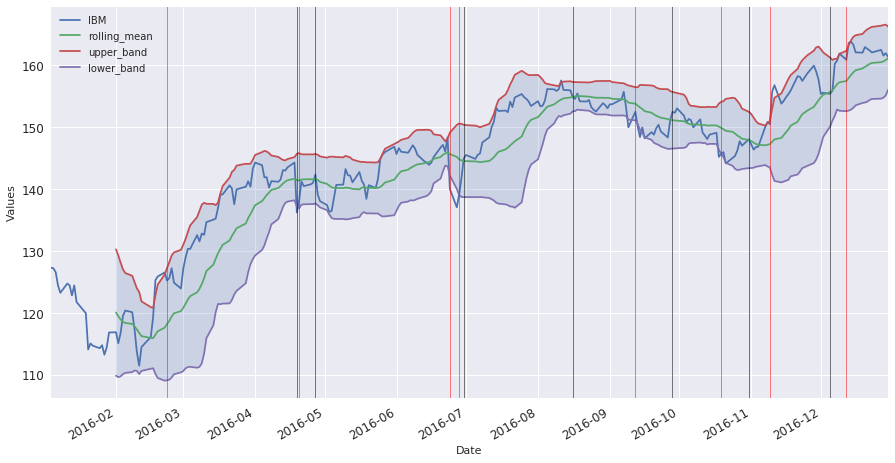

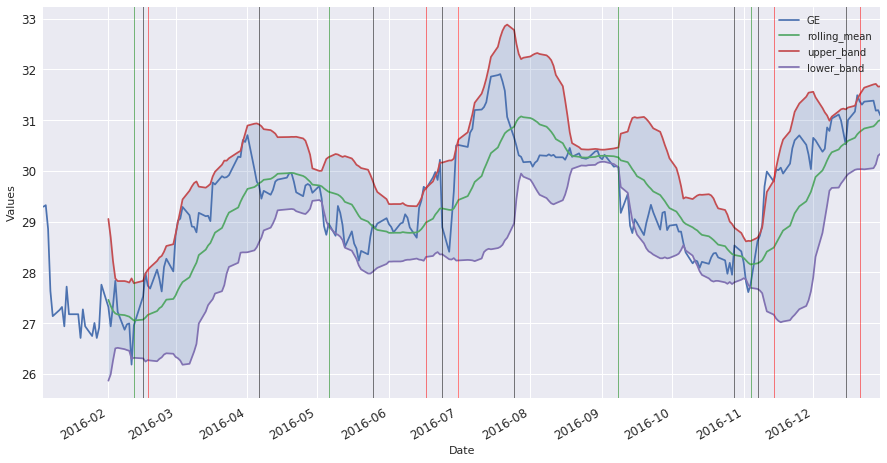

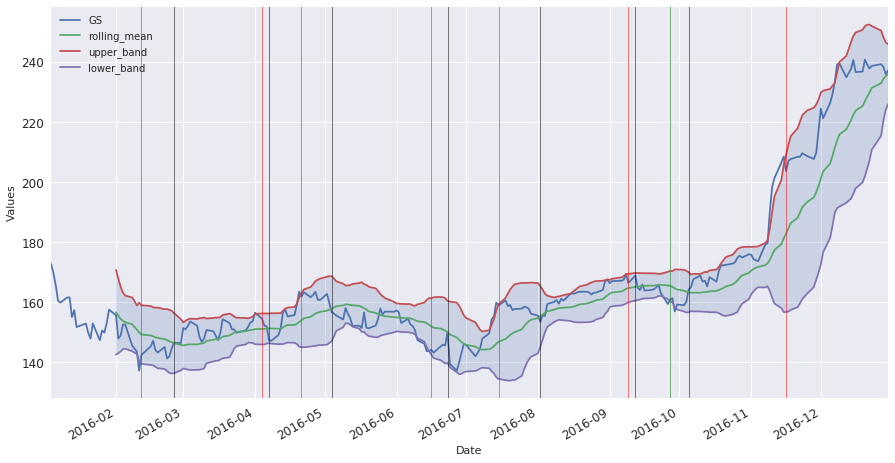

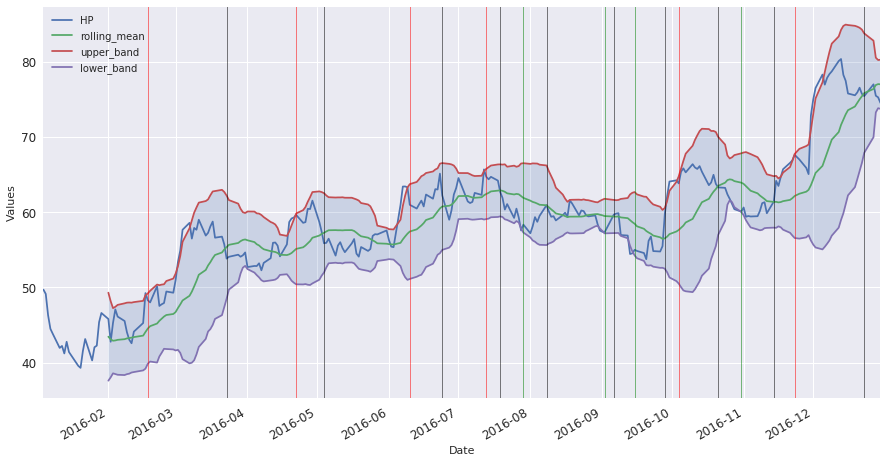

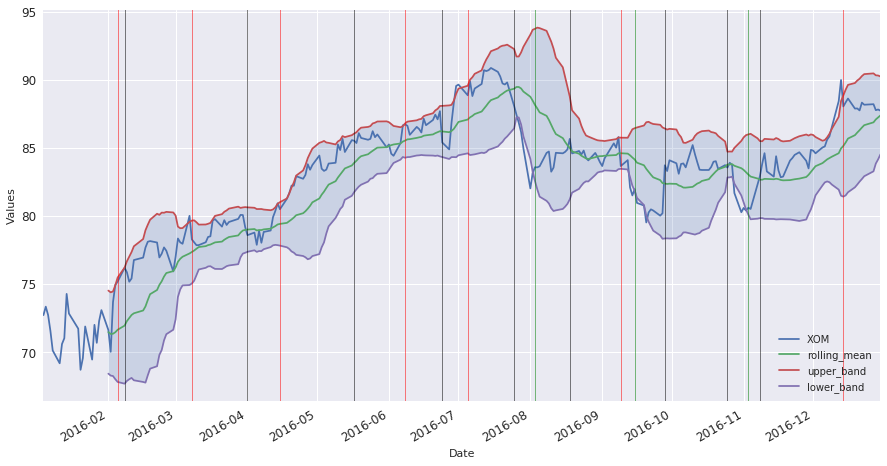

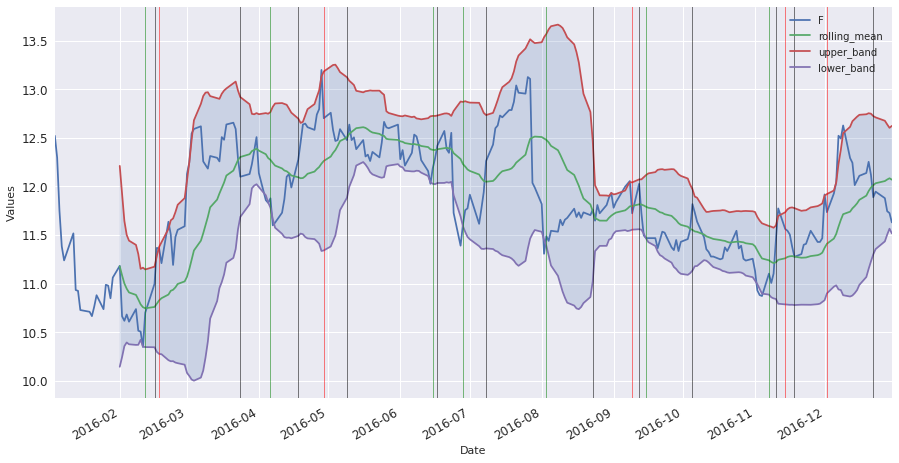

In [44]:
start_date = '2016-01-01'
end_date = '2016-12-31'
list_stocks = ['AAPL','GOOG','AMZN','AXP','BAC','BA','KO','FB','IBM','GE', 'GS','HP', 'XOM', 'F']
for stock in list_stocks:
    generate_orders_2(stock, start_date, end_date)

In [45]:
pd.read_csv('order/orders_strategy_2.txt').head()

Date Ticker       Order  Volumn
0  2016-03-07   AAPL       SHORT     100
1  2016-04-18   AAPL  SELL_SHORT     100
2  2016-05-03   AAPL         BUY     100
3  2016-05-20   AAPL        SELL     100
4  2016-05-27   AAPL       SHORT     100